In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import json
from scipy import optimize
from scipy.signal import savgol_filter
import scipy.stats as stats
import zipfile
Image.MAX_IMAGE_PIXELS = 3000000000
from matplotlib.patches import Polygon
import shapely.wkt
import shapely
from planetaryimage import CubeFile

# SFD

In [2]:
def sfd(path_to_data,resolution=0.5):
    data = pd.read_csv(path_to_data)
    lengths = data['major axis length']
    length_hist = np.histogram(lengths,bins=np.arange(0,50,2))
    bins = length_hist[1][:-1]*0.5
    #Cumulative
    length_hist_sum = np.zeros(len(length_hist[0]))
    for i in range(len(length_hist[0])-1,-1,-1):
        sum = 0
        for j in range(len(length_hist[0])-i):
            sum = sum + length_hist[0][i+j]
        length_hist_sum[i] = sum

    return bins, length_hist_sum

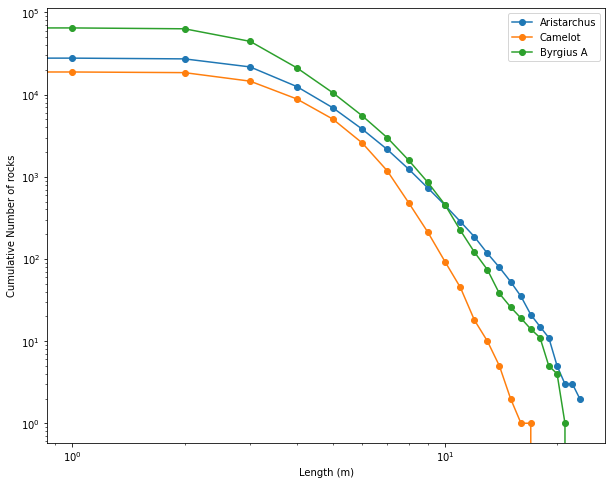

In [3]:
bins_1, cumu_number_1 = sfd("../results/M144931504LC/rock_detections.csv")
bins_2, cumu_number_2 = sfd("../results/M165645700LE/rock_detections.csv")
bins_3, cumu_number_3 = sfd("../results/M1265236990RE/rock_detections.csv")

plt.figure(figsize=(10,8))
plt.plot(bins_1,cumu_number_1,marker="o",label="Aristarchus")
plt.plot(bins_2,cumu_number_2,marker="o",label="Camelot")
plt.plot(bins_3,cumu_number_3,marker="o",label="Byrgius A")
plt.xlabel("Length (m)")
plt.ylabel("Cumulative Number of rocks")
plt.loglog()
plt.legend()

# Slope

In [14]:
if not os.path.exists("../../unpacked_images/"):
    os.makedirs("../../unpacked_images/")

In [15]:
with zipfile.ZipFile("../data/images/cutouts_M144931504LC.zip", "r") as zip_ref:
    zip_ref.extractall("../../unpacked_images/")

In [4]:
def gauss(x,A,mu,sig,d):
    return A*np.exp(-(x-mu)**2/(2*sig**2))+d

def ricker_wavelet(x,A,B,mu,sig,d,e):
    return A*(1-B*(x-mu)**2/sig**2)*np.exp(-(x-mu)**2/(2*sig**2))+d*(x-mu)+e

def ricker_and_gauss(x,A1,mu1,sig1,A2,B2,mu2,sig2,e):
    return A2*(1-B2*(x-mu2)**2/sig2**2)*np.exp(-(x-mu2)**2/(2*sig2**2))+ A1*np.exp(-(x-mu1)**2/(2*sig1**2))+e#+d*(x-mu2)+e

def two_gauss(x,A1,mu1,sig1,A2,mu2,sig2,e):
    return A1*np.exp(-(x-mu1)**2/(2*sig1**2))+A2*np.exp(-(x-mu2)**2/(2*sig2**2))+e

In [129]:
def extract_interesting_detections(data,path_to_image,path_to_cube,sun_angle,num_rocks=1,start_index=0,show_plot=False):
    
    #Detection image
    image = Image.open(path_to_image)
    image = image.convert("RGB")

    #Reflectance data
    image_refl = CubeFile.open(path_to_cube)
    image_refl = image_refl.data[0]
    image_refl[image_refl<-3e+38] = 0

    reflectances, deviations = [], []
    fillet_heights, fillet_widths, fillet_widths_percent, fillet_slopes = [], [], [], []

    for i in range(start_index,start_index+num_rocks):
        
        try:
            roi = json.loads(data['roi'].iloc[i])
        except:
            print("DataFrame Error:",i)

        offset_factor = 1.5
        offset_x = int(np.round(offset_factor*(roi[3]-roi[1])))
        offset_y = int(np.round(offset_factor*(roi[2]-roi[0])))
        box = (roi[1]-offset_x,roi[0]-offset_y,roi[3]+offset_x,roi[2]+offset_y)
        image_det = np.asarray(image.crop(box))
        image_refl_det = image_refl[box[1]:box[3],box[0]:box[2]]

        mask_x, mask_y = shapely.wkt.loads(data['mask'].iloc[i]).exterior.coords.xy
        shifted_mask_x = np.array(mask_x)-(roi[1]-offset_x)
        shifted_mask_y = ((-1)*np.array(mask_y))-(roi[0]-offset_y)
        shifted_mask = [[shifted_mask_x[j],shifted_mask_y[j]] for j in range(len(shifted_mask_x))]

        title = 'Image: {} - Detected Rock No. {} - Position: ({}, {}) - Measured length: {:.0f} px, bright area: {:.0f} px$^2$'.format(path_to_image.split("/")[-1].split(".")[0],i,int(data["center_x"].iloc[i]),int(data["center_y"].iloc[i]),data["major axis length"].iloc[i],data["area"].iloc[i])
        try:
            reflectance, deviation, fillet_height, fillet_width, fillet_width_percent, fillet_slope = plot_brightness_profile(image_det,image_refl_det,sun_angle,np.round(data["center_x"].iloc[i]-(roi[1]-offset_x)),np.round(data["center_y"].iloc[i]-(roi[0]-offset_y)),roi,shifted_mask,offset_x,offset_y,title,show_plot=show_plot)
            reflectances.append(reflectance)
            deviations.append(deviation)
            if fillet_height > 0 and fillet_height < 1:
                fillet_heights.append(fillet_height)
                fillet_widths.append(fillet_width)
                fillet_slopes.append(fillet_slope)
                fillet_widths_percent.append(fillet_width_percent)
        except:
            deviations.append(1)
    
    if not show_plot:
        data["mean deviation fit"] = deviations

    print("Min deviation:",np.min(deviations),"at",np.argmin(deviations))
    return reflectances, data, fillet_heights, fillet_widths, fillet_widths_percent, fillet_slopes

def get_reflectance_profile(azimuth,image_det,x_mid,y_mid,max_length):
    slope, b = azimuth_sunlight(azimuth,x_mid,y_mid)
    xs = np.arange(0,max_length,1)
    ys = slope*xs + b
    reflectance = []
    for i in range(len(xs)):
        if ys[i] < 0:
            reflectance.append(0)
        else:
            if image_det.ndim == 3:
                reflectance.append(image_det[np.round(ys[i]).astype(int),xs[i],0])
            elif image_det.ndim == 2:
                reflectance.append(image_det[np.round(ys[i]).astype(int),xs[i]])
    return reflectance, xs, ys

def azimuth_sunlight(azimuth,x_mid,y_mid):
    slope = np.tan(np.radians(azimuth))
    b = y_mid - slope*x_mid
    return slope, b

def plot_brightness_profile(data_image,data_reflectance,angle,cent_x,cent_y,roi,mask,offset_x,offset_y,title,show_plot=False):
    max_length = (roi[3]+offset_x)-(roi[1]-offset_x)
    reflectance, x_light, y_light = get_reflectance_profile(angle,data_reflectance,cent_x,cent_y,max_length)
    
    light_2d = [[x_light[i],y_light[i]] for i in range(len(x_light))]

    line = shapely.geometry.LineString(light_2d)
    polygon = shapely.geometry.Polygon(mask)

    x_intersect, _ = line.intersection(polygon).xy

    #smoothed_reflectance = savgol_filter(reflectance, 5, 3)
    xs = np.arange(int(x_light[0]),int(np.round(cent_x))+2,1)
    fit_successful = False
    try:
        params, covariance = optimize.curve_fit(two_gauss,xs,reflectance[xs[0]:xs[-1]+1],\
                        p0=[0.12,x_intersect[0],3,0.1,cent_x,5,0.02],\
                        bounds=([0,x_intersect[0]-1,0,0,cent_x-3,0,0], [1,x_intersect[0]+1,x_intersect[0],1,cent_x+3,np.inf,1]),maxfev=10000)
        deviation = mean_deviation(two_gauss(xs,params[0],params[1],params[2],params[3],params[4],params[5],params[6]),np.array(reflectance[xs[0]:xs[-1]+1]))

        #Morphological parameters
        #Fillet
        x_test = np.linspace(0,x_intersect[0],100)
        fillet1_x = 0
        for j in range(len(x_test)):
            if np.abs(two_gauss(x_test[j],params[0],params[1],params[2],params[3],params[4],params[5],params[6])-params[6])>0.001:
                fillet1_x = int(np.round(x_test[j]))
                break

        fillet1_y = two_gauss(fillet1_x,params[0],params[1],params[2],params[3],params[4],params[5],params[6])

        #IDEA: Use (going from left) first point in third derivative that differs (positive, not absolute) from 0 more than e.g. 0.0001 (left onset)

        fit_function = two_gauss(xs,params[0],params[1],params[2],params[3],params[4],params[5],params[6])

        third_deriv_fit = np.gradient(np.gradient(np.gradient(fit_function,1),1),1)
        max_reflectance_fit = np.argmax(fit_function)
        fillet2_x = np.argmax(third_deriv_fit[:max_reflectance_fit])
        fillet2_y = two_gauss(fillet2_x,params[0],params[1],params[2],params[3],params[4],params[5],params[6])

        #Rock
        rock_max_y = np.max(two_gauss(xs,params[0],params[1],params[2],params[3],params[4],params[5],params[6]))
        rock_max_x = np.argmax(two_gauss(xs,params[0],params[1],params[2],params[3],params[4],params[5],params[6]))

        #Parameters
        fillet_height = (fillet2_y-fillet1_y)/(rock_max_y-params[6])
        fillet_width = fillet2_x-fillet1_x
        fillet_width_percent = fillet_width/(x_intersect[-1]-x_intersect[0])

        fillet_slope = (fillet2_y-fillet1_y)/(fillet2_x-fillet1_x)

        fit_successful = True
    
    except:
        pass

    if show_plot:
            fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(24,5))
            fig.suptitle(title,fontweight="bold")

            im = ax[0].imshow(data_image,cmap='gray')
            plt.colorbar(im, ax=ax[0])
            ax[0].scatter(cent_x,cent_y,color="red")
            ax[0].add_patch(Polygon(mask,fill=False,color="lime"))
            ax[0].plot(x_light,y_light,color="orange")
            ax[0].set_title('detection image (greyscale)')

            im = ax[1].imshow(data_reflectance,cmap='gray')
            plt.colorbar(im, ax=ax[1])
            ax[1].scatter(cent_x,cent_y,color="red")
            ax[1].add_patch(Polygon(mask,fill=False,color="lime"))
            ax[1].plot(x_light,y_light,color="orange")
            ax[1].set_title('reflectance image (I/F)')
            
            ax[2].plot(reflectance)
            ax[2].set_title('reflectance profile (I/F)')

            fit_function = two_gauss(xs,params[0],params[1],params[2],params[3],params[4],params[5],params[6])
            if fit_successful:
                ax[2].plot(xs,fit_function)
                text = "A1: {:.3f}, mu1: {:.3f}, sig1: {:.3f}, A2: {:.3f}, mu2: {:.3f}, sig2: {:.3f}, e: {:.3f}".format(params[0],params[1],params[2],params[3],params[4],params[5],params[6])
                
                ax[2].scatter(fillet1_x,fillet1_y,color="purple")
                ax[2].scatter(fillet2_x,fillet2_y,color="purple")
                ax[2].scatter(rock_max_x,rock_max_y,color="green")
                ax[2].hlines(params[6],x_light[0],x_light[-1],linestyles="--",color="slategray")
                ax[2].fill_between(xs[fillet1_x:fillet2_x+1], params[6], fit_function[fillet1_x:fillet2_x+1],color="khaki")
                ax[2].fill_between(x_light[fillet2_x:int(x_intersect[-1])+1], params[6], reflectance[fillet2_x:int(x_intersect[-1])+1],color="lightsteelblue")

                ax[3].plot(third_deriv_fit)
                ax[3].scatter(fillet2_x, third_deriv_fit[fillet2_x],color="orange")
                ax[2].scatter(fillet2_x, fit_function[fillet2_x],color="orange")
                ax[3].set_title('fit profile 3rd derivative')

                text_results = "Deviation: {:.5f}, fillet height (%): {:.1%}, fillet width (px): {:.1f}, fillet width (%): {:.1%}, fillet slope: {:.4f}"\
                    .format(deviation, fillet_height, fillet_width, fillet_width_percent, fillet_slope)

            else:
                text = "Fit could not be calculated."
                text_results = ""
            ax[2].scatter(cent_x,reflectance[int(np.round(cent_x))],color="red")
            ax[2].vlines(x_intersect[0],np.min(reflectance),np.max(reflectance),color="lime")
            ax[2].vlines(x_intersect[-1],np.min(reflectance),np.max(reflectance),color="lime")
            
            fig.text(.5,.05,text, ha='center')  
            fig.text(.5,0,text_results, ha='center')  
    else:
            pass 
    
    return reflectance, deviation, fillet_height, fillet_width, fillet_width_percent, fillet_slope

In [6]:
def mean_deviation(fit, exp):
     deviation = np.mean(np.abs(fit-exp))/np.max(exp)
     return deviation

In [51]:
def get_max_reflectance(path_to_data,path_to_cube):
    data = pd.read_csv(path_to_data)

    #Reflectance data
    image_refl = CubeFile.open(path_to_cube)
    image_refl = image_refl.data[0]
    image_refl[image_refl<-3e+38] = 0

    max_reflectances = []
    #For all detected rocks
    for i in range(len(data)):
        roi = json.loads(data['roi'].iloc[i])
        image_refl_det = image_refl[roi[0]:roi[2],roi[1]:roi[3]]

        maximum_refl = np.max(image_refl_det)
        max_reflectances.append(maximum_refl)
        
    data["maximum reflectance"] = max_reflectances
    return data

In [35]:
#Another idea
#Calculate nearest neighbours
#Extract single rocks

### Real

In [67]:
#Data
path_data_aristarchus = "../results/M144931504LC/rock_detections.csv"
path_data_camelot = "../results/M165645700LE/rock_detections.csv"
path_data_byrgius = "../results/M1265236990RE/rock_detections.csv"

#Images
path_image_aristarchus = "C:/Users/b_auss01/sciebo/Inhalt/Data/MoonRocks256/M144931504LC.tif"
path_image_camelot = "C:/Users/b_auss01/sciebo/Inhalt/Data/MoonRocks256/M165645700LE.tif"
path_image_byrgius = "C:/Users/b_auss01/sciebo/Inhalt/Data/MoonRocks256/M1265236990RE.tif"

#Cubes
path_cube_aristarchus = "../../data/M144931504LE_lev1.echo.cub"
path_cube_camelot = "../../data/M165645700LE_lev1.echo.cub"
path_cube_byrgius = "../../data/M1265236990RE_lev1.echo.cub"

#DataFrames
data_aristarchus = get_max_reflectance(path_data_aristarchus,path_cube_aristarchus)
data_camelot = get_max_reflectance(path_data_camelot,path_cube_camelot)
data_byrgius = get_max_reflectance(path_data_byrgius,path_cube_byrgius)

#Restrictions
data_restr_aristarchus = data_aristarchus[data_aristarchus["maximum reflectance"]>0.12][data_aristarchus["major axis length"]>15][data_aristarchus["major axis length"]<65]
print(len(data_restr_aristarchus))
data_restr_camelot = data_camelot[data_camelot["maximum reflectance"]>0.05][data_camelot["major axis length"]>15][data_camelot["major axis length"]<65]
print(len(data_restr_camelot))
data_restr_byrgius = data_byrgius[data_byrgius["maximum reflectance"]>0.12][data_byrgius["major axis length"]>15][data_byrgius["major axis length"]<65]
print(len(data_restr_byrgius))

666
335
1567


C:\Users\b_auss01\AppData\Local\Temp\ipykernel_13052\3205074962.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_restr_aristarchus = data_aristarchus[data_aristarchus["maximum reflectance"]>0.12][data_aristarchus["major axis length"]>15][data_aristarchus["major axis length"]<65]
C:\Users\b_auss01\AppData\Local\Temp\ipykernel_13052\3205074962.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_restr_camelot = data_camelot[data_camelot["maximum reflectance"]>0.05][data_camelot["major axis length"]>15][data_camelot["major axis length"]<65]
C:\Users\b_auss01\AppData\Local\Temp\ipykernel_13052\3205074962.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_restr_byrgius = data_byrgius[data_byrgius["maximum reflectance"]>0.12][data_byrgius["major axis length"]>15][data_byrgius["major axis length"]<65]


In [68]:
reflectances_aris, data_fit_aris, fillet_heights_aris, fillet_widths_aris, fillet_widths_percent_aris, fillet_slopes_aris = \
    extract_interesting_detections(data_restr_aristarchus,path_image_aristarchus,path_cube_aristarchus,sun_angle=161.82,num_rocks=len(data_restr_aristarchus),start_index=0,show_plot=False)
data_fit_aris = data_fit_aris.sort_values("mean deviation fit",ascending=True)

reflectances_camelot, data_fit_camelot, fillet_heights_camelot, fillet_widths_camelot, fillet_widths_percent_camelot, fillet_slopes_camelot = \
    extract_interesting_detections(data_restr_camelot,path_image_camelot,path_cube_camelot,sun_angle=161.82,num_rocks=len(data_restr_camelot),start_index=0,show_plot=False)
data_fit_camelot = data_fit_camelot.sort_values("mean deviation fit",ascending=True)

reflectances_byrgius, data_fit_byrgius, fillet_heights_byrgius, fillet_widths_byrgius, fillet_widths_percent_byrgius, fillet_slopes_byrgius = \
    extract_interesting_detections(data_restr_byrgius,path_image_byrgius,path_cube_byrgius,sun_angle=161.82,num_rocks=len(data_restr_byrgius),start_index=0,show_plot=False)
data_fit_byrgius = data_fit_byrgius.sort_values("mean deviation fit",ascending=True)

C:\Users\b_auss01\AppData\Local\Temp\ipykernel_13052\2432111846.py:122: RuntimeWarning: invalid value encountered in double_scalars
  fillet_slope = (fillet2_y-fillet1_y)/(fillet2_x-fillet1_x)


Min deviation: 0.006700713859741616 at 275


C:\Users\b_auss01\AppData\Local\Temp\ipykernel_13052\2432111846.py:122: RuntimeWarning: invalid value encountered in double_scalars
  fillet_slope = (fillet2_y-fillet1_y)/(fillet2_x-fillet1_x)


Min deviation: 0.013407109935237157 at 256


C:\Users\b_auss01\AppData\Local\Temp\ipykernel_13052\2432111846.py:122: RuntimeWarning: invalid value encountered in double_scalars
  fillet_slope = (fillet2_y-fillet1_y)/(fillet2_x-fillet1_x)


Min deviation: 0.006007474901800561 at 891


In [133]:
#Aristarchus
_,_,_,_,_,_ = extract_interesting_detections(data_fit_aris,path_image_aristarchus,path_cube_aristarchus,sun_angle=161.82,num_rocks=100,start_index=0,show_plot=True)

Min deviation: 0.006007474901800561 at 0


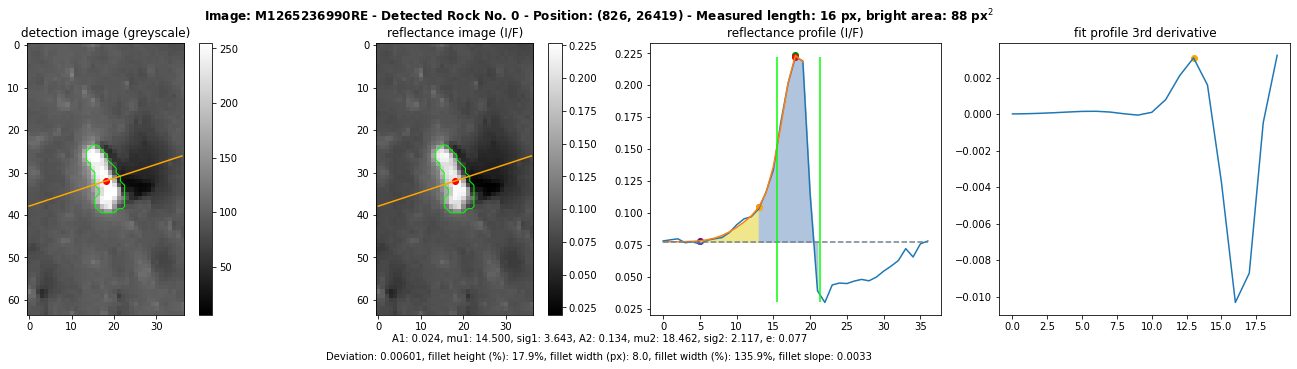

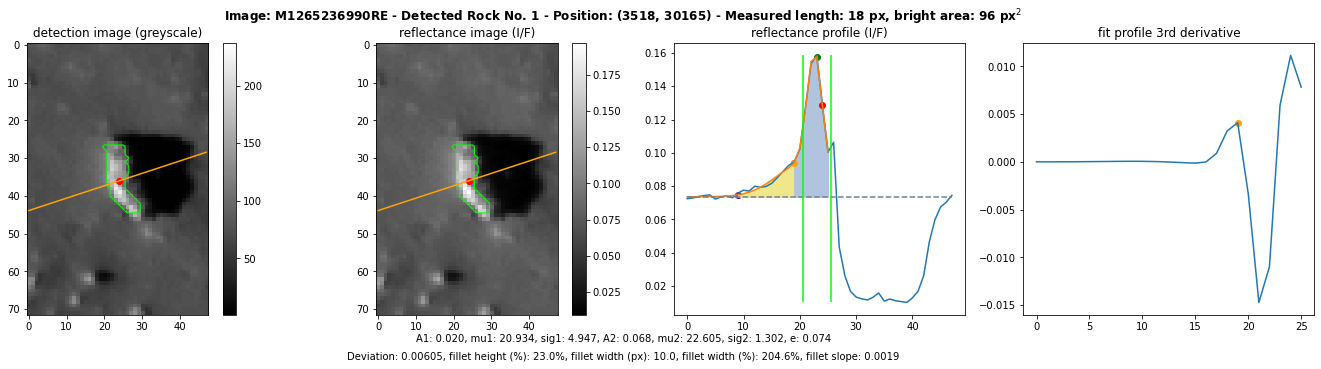

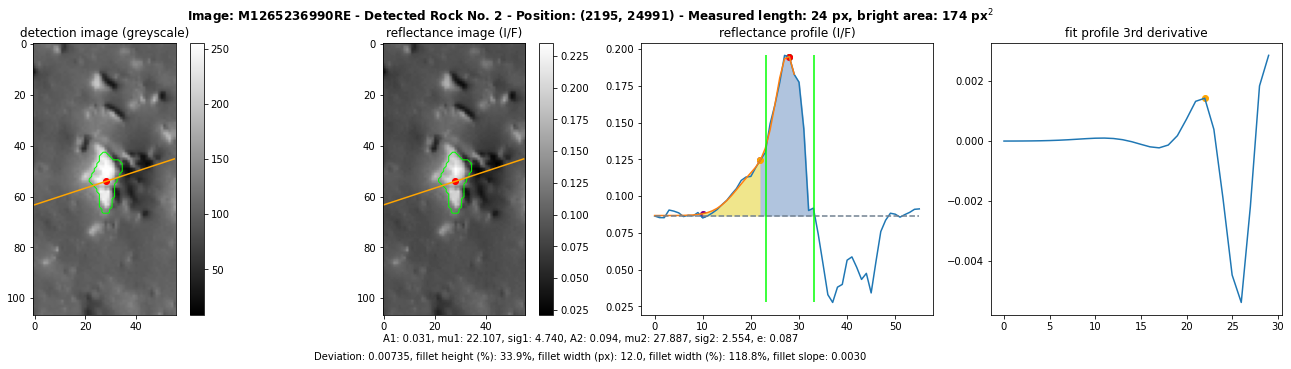

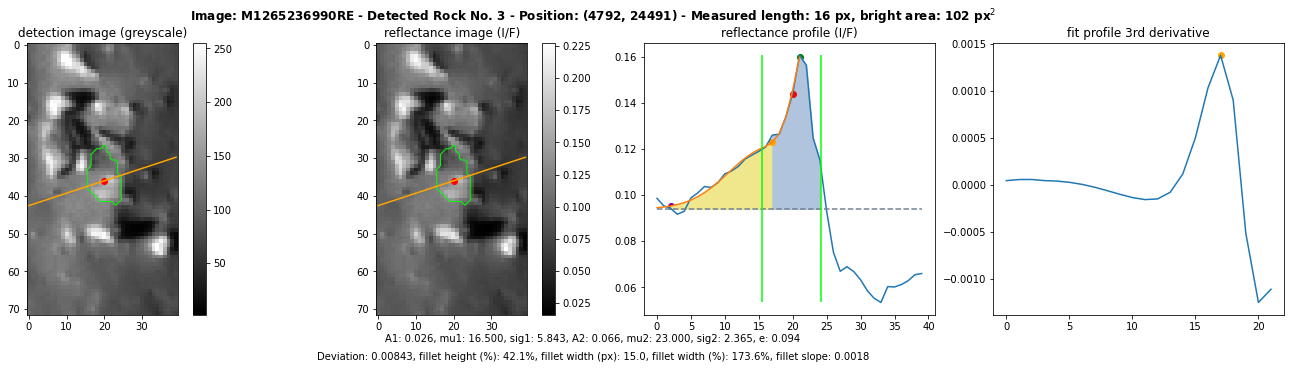

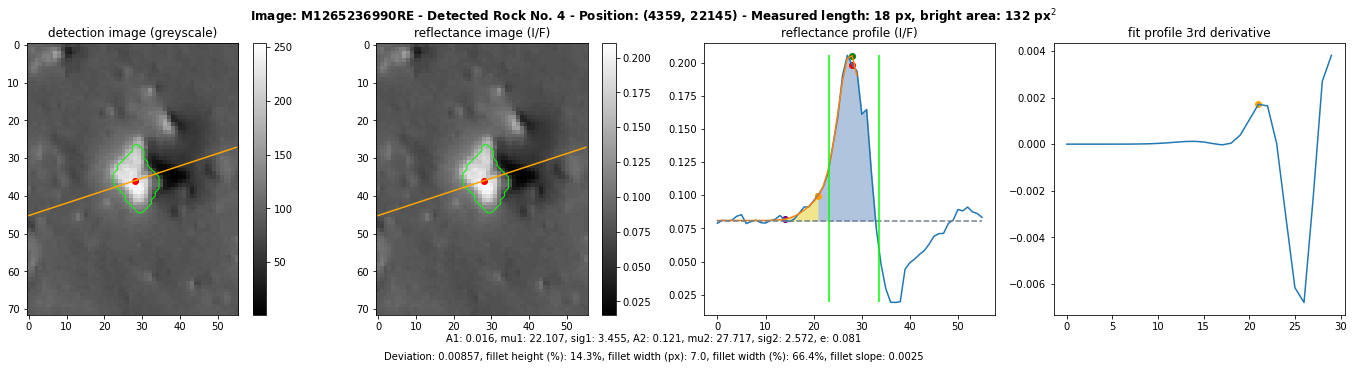

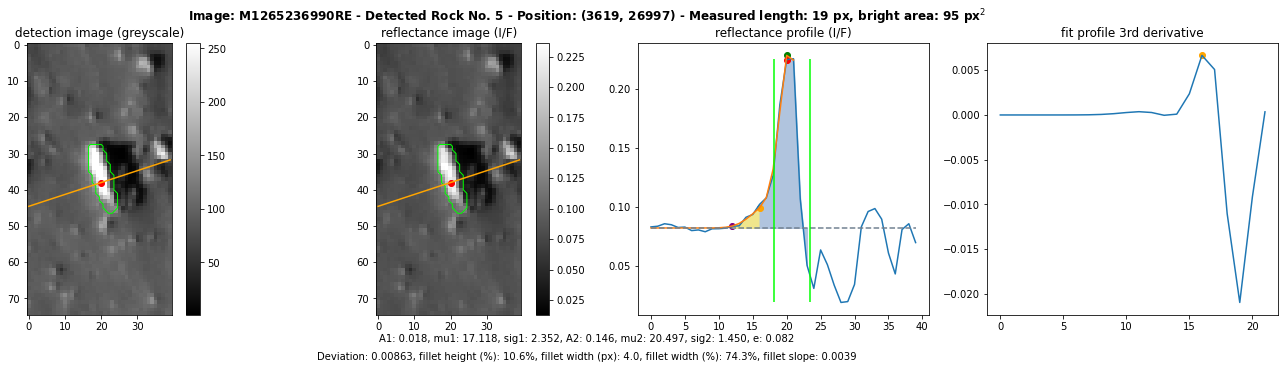

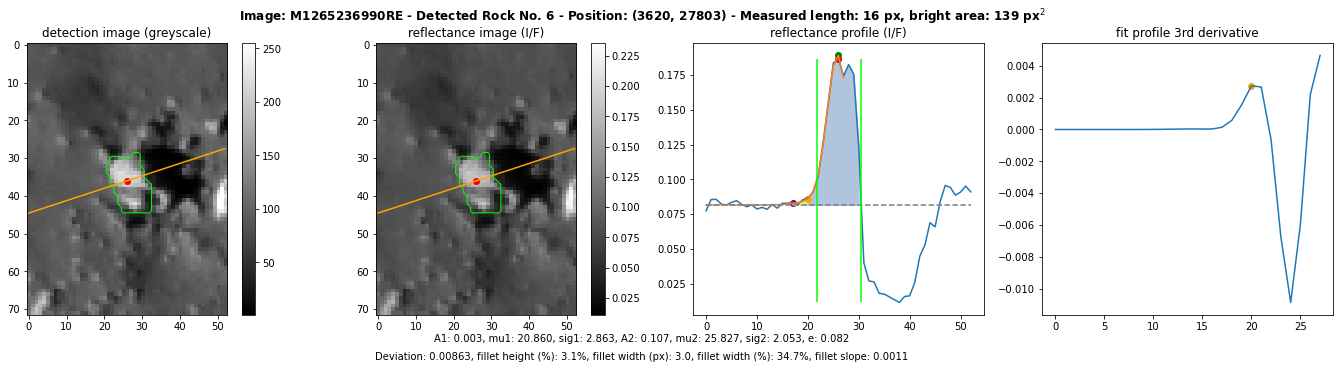

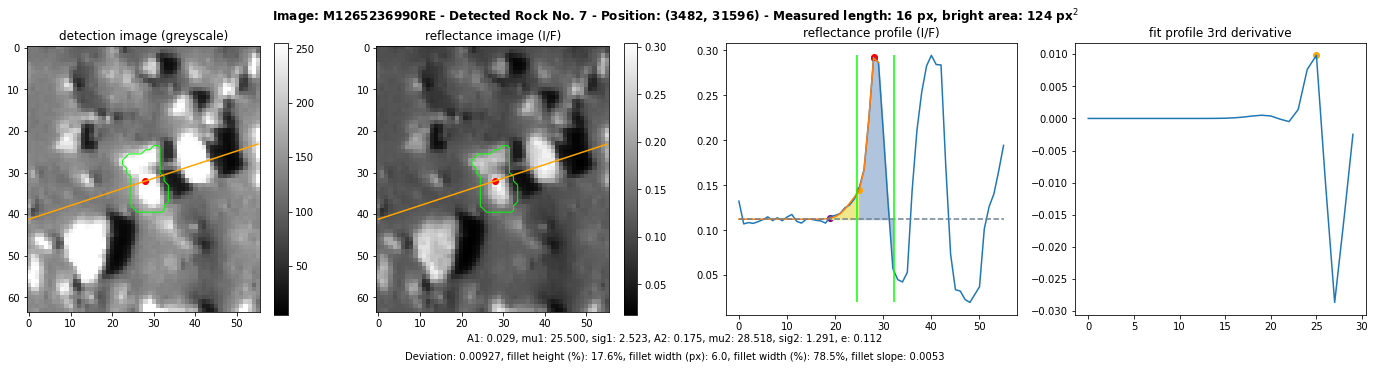

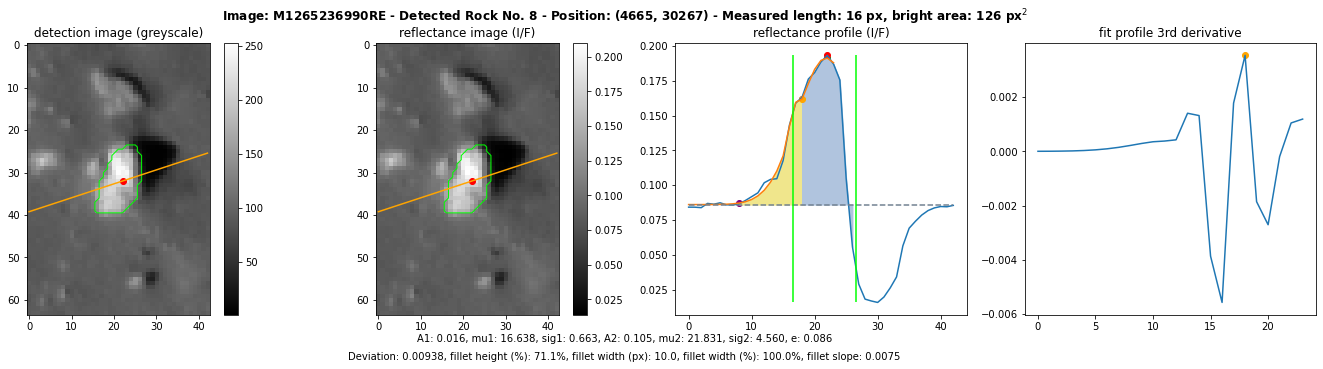

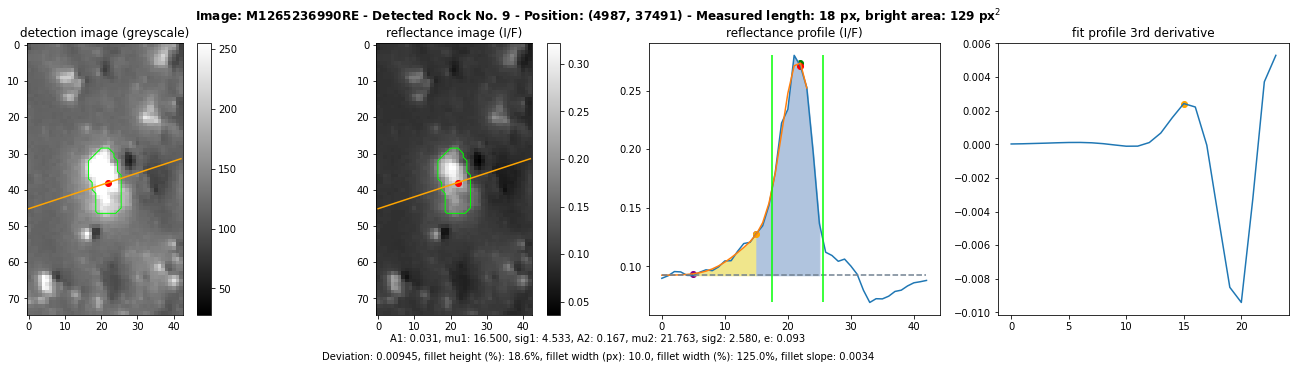

In [131]:
#Byrgius
_,_,_,_,_,_ = extract_interesting_detections(data_fit_byrgius,path_image_byrgius,path_cube_byrgius,sun_angle=161.82,num_rocks=10,start_index=0,show_plot=True)

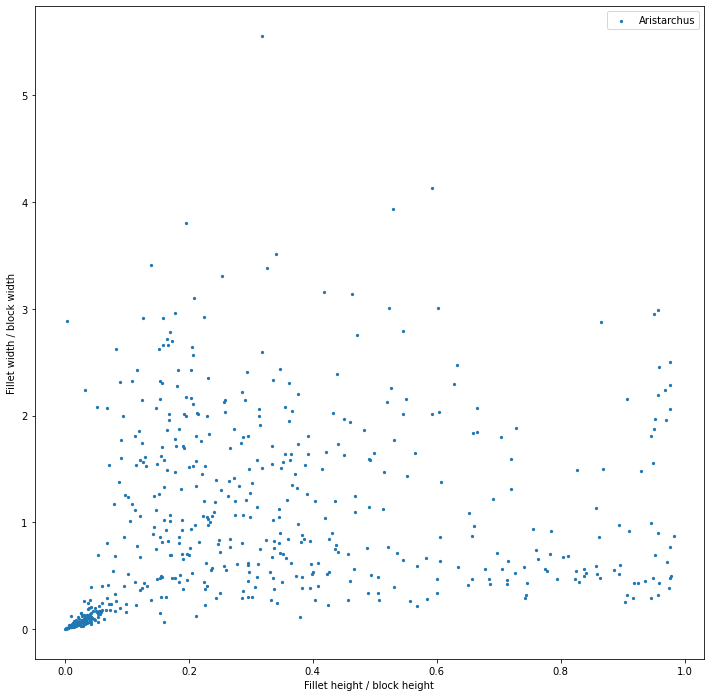

In [86]:
plt.figure(figsize=(12,12))
plt.scatter(fillet_heights_aris, fillet_widths_percent_aris,s=5,label="Aristarchus")
#plt.scatter(fillet_heights_byrgius, fillet_widths_percent_byrgius,s=5,label="Byrgius A")
plt.xlabel("Fillet height / block height")
plt.ylabel("Fillet width / block width")
plt.legend()

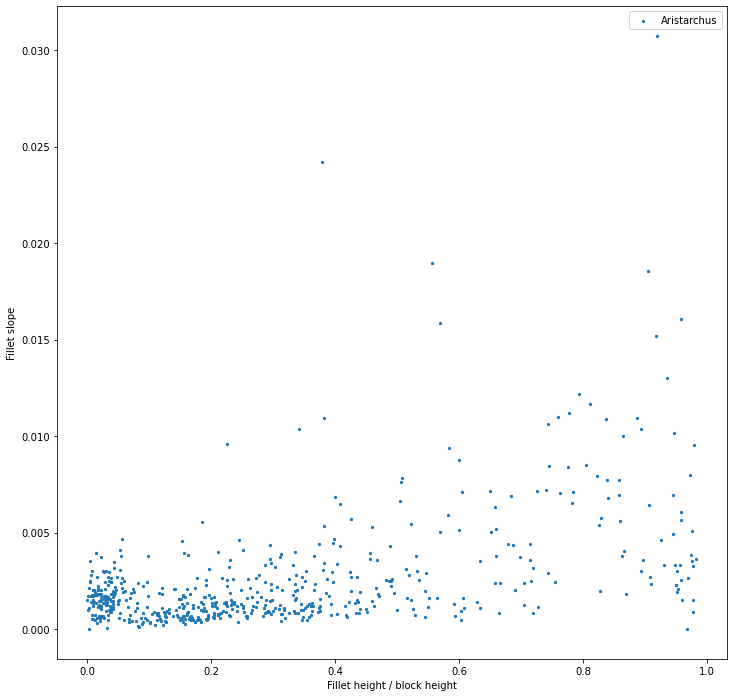

In [87]:
plt.figure(figsize=(12,12))
plt.scatter(fillet_heights_aris, fillet_slopes_aris,s=5,label="Aristarchus")
#plt.scatter(fillet_heights_byrgius, fillet_slopes_byrgius,s=5,label="Byrgius A")
plt.xlabel("Fillet height / block height")
plt.ylabel("Fillet slope")
plt.legend()

A: 76.94121899240044 +- 6.852371286373548
B: 1.3195386152229052 +- 0.17260201549617663
mu: 104.25824793365784 +- 0.05105095072193894
sig: 2.8615009021208797 +- 0.0718289305288111
d: -0.1562080366995431 +- 0.38823829504564894
e: 116.06842589667993 +- 5.877609596033804


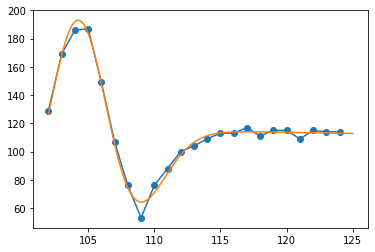

In [ ]:
A, B, mu, sig, d, e = fit_brightness_profile_gauss(xs,brightnesses[index][x_min:x_max],p0=[130,1,103,2,120,1])
x_fit = np.linspace(x_min,x_max,1000)
plt.plot(xs,brightnesses[index][x_min:x_max],marker="o")
plt.plot(x_fit,ricker_wavelet(x_fit,A,B,mu,sig,d,e))

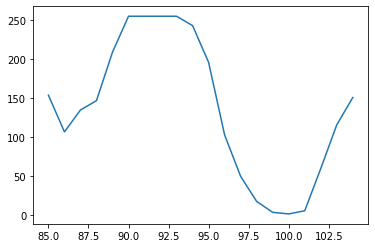

In [ ]:
index = 7
x_min, x_max = rois_x[index][0], rois_x[index][1]
x_min, x_max = 85, 105
xs = np.arange(x_min,x_max,1)
plt.plot(xs,brightnesses[index][x_min:x_max])

A: -0.009176893012486288 +- 50.081838440471714
B: 33859.96912047805 +- 184220463.3494442
mu: 99.09681103916354 +- 0.26314451502906555
sig: 4.605730409896906 +- 0.24447906359181387
d: -7.648200818979248 +- 3.364712597992364
e: -13.034934845724344 +- 46.92124991698479


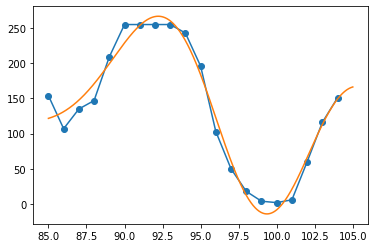

In [ ]:
A, B, mu, sig, d, e = fit_brightness_profile_gauss(xs,brightnesses[index][x_min:x_max],p0=[130,1,103,2,120,1])
x_fit = np.linspace(x_min,x_max,1000)
plt.plot(xs,brightnesses[index][x_min:x_max],marker="o")
plt.plot(x_fit,ricker_wavelet(x_fit,A,B,mu,sig,d,e))

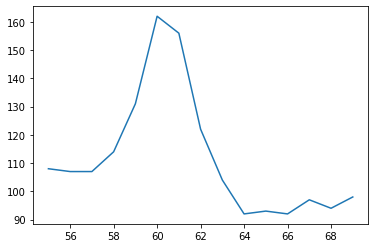

In [ ]:
index = 19
x_min, x_max = rois_x[index][0], rois_x[index][1]
x_min, x_max = 55, 70
xs = np.arange(x_min,x_max,1)
plt.plot(xs,brightnesses[index][x_min:x_max])

A: 63.27591137927578 +- 3.9492611672187854
B: -1.1874866605830406e-05 +- 37.1084787277748
mu: 60.39002515680039 +- 0.06964282810816047
sig: 1.125144909940787 +- 41.76018802771729
d: -1.088154478371967 +- 0.23183186165381228
e: 101.65453953107372 +- 1.3576983714572157


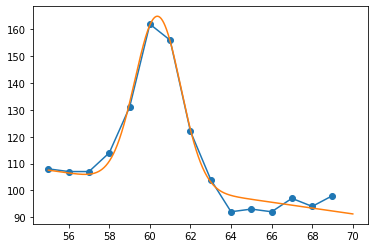

In [ ]:
A, B, mu, sig, d, e = fit_brightness_profile_gauss(xs,brightnesses[index][x_min:x_max],p0=[70,0,60,2,-1,90])
x_fit = np.linspace(x_min,x_max,1000)
plt.plot(xs,brightnesses[index][x_min:x_max],marker="o")
plt.plot(x_fit,ricker_wavelet(x_fit,A,B,mu,sig,d,e))

### Artificial

In [13]:
def fit_function_1(x,A1,mu1,sig1,A2,mu2,sig2,d):
    return gauss(x,A1,mu1,sig1)+gauss(x,A2,mu2,sig2)+d

def fit_brightness_profile_1(xs,brightnesses,p0):
    params, covariance = optimize.curve_fit(fit_function_1,xs,brightnesses,p0=p0,maxfev=10000)
    uncert = np.sqrt(np.diag(covariance))
    print("A1:",params[0],"+-",uncert[0])
    print("mu1:",params[1],"+-",uncert[1])
    print("sig1:",params[2],"+-",uncert[2])
    print("A2:",params[3],"+-",uncert[3])
    print("mu2:",params[4],"+-",uncert[4])
    print("sig2:",params[5],"+-",uncert[5])
    print("d:",params[6],"+-",uncert[6])
    return params[0],params[1],params[2],params[3],params[4],params[5],params[6]

In [171]:
def plot_brightness_profile_artificial(data_image,angle,cent_x,cent_y,roi,offset,title,max_length=255,show_plot=False):
    brightness, x_light, y_light = get_brightness_profile(angle,data_image,cent_x,cent_y,max_length)

    if show_plot:
            fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(11,5))
            
            fig.suptitle(title)

            ax[0].imshow(data_image,cmap='gray')
            ax[0].scatter(cent_x,cent_y,color="red")
            ax[0].plot(x_light,y_light,color="orange")
            ax[0].set_xlim(roi[1]-offset,roi[3]+offset)
            ax[0].set_ylim(roi[2]+offset,roi[0]-offset)
            ax[0].set_title('image')
            
            ax[1].plot(brightness)
            ax[1].set_xlim(roi[1]-offset,roi[3]+offset)
            ax[1].set_title('reflectance profile (arb. unit)')
            ax[1].arrow(200,30000,0,8000,width=6,head_length=2500,color="green")
            ax[1].arrow(220,12000,30,0,width=1500,head_length=10,color="red")
            fig.show()
    else:
            pass 
    return brightness

C:\Users\b_auss01\AppData\Local\Temp\ipykernel_12068\6687537.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


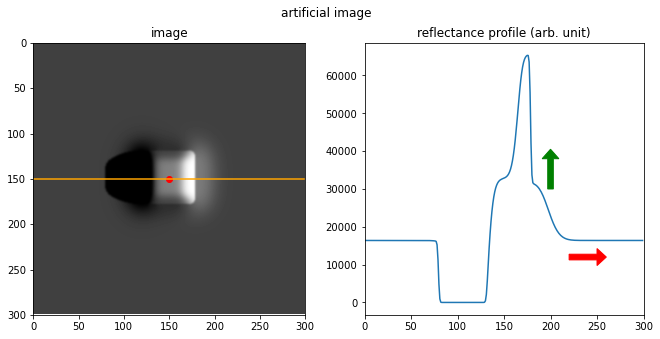

In [172]:
path_image = "../../../Data/ArtificialBoulderImagesForPaper/"
roi = [25,25,275,275]
image_det = Image.open(path_image+"ID245_50000_60.png")
#image_det = image_det.convert("RGB")
image_det = np.asarray(image_det)

offset = 25
brightness = plot_brightness_profile_artificial(image_det,0,150,150,roi,offset,title="artificial image",max_length=300,show_plot=True)

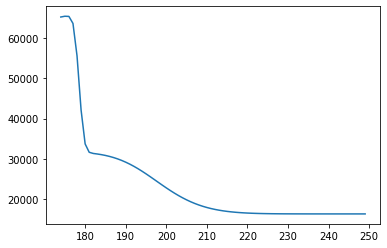

In [ ]:
x_min, x_max = 174, 250
xs = np.arange(x_min,x_max,1)
plt.plot(xs,brightness[x_min:x_max])

A1: 43106.42173761338 +- 1110.4429470255027
mu1: 175.27080928407588 +- 0.07294821132089035
sig1: 2.605690290513166 +- 0.09309738561683666
A2: 13800.868215929964 +- 327.8981196569909
mu2: 185.86194897146095 +- 0.8303176915506804
sig2: 11.419513091043239 +- 0.6723111102793533
d: 16417.17258866325 +- 149.15456607395592


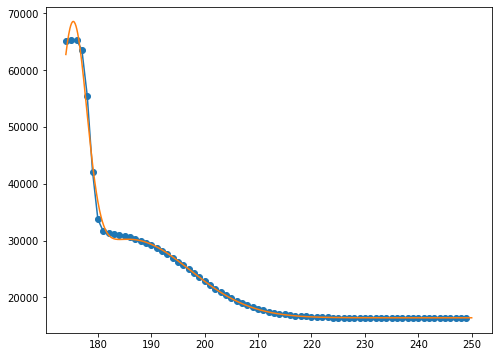

In [ ]:
A1, mu1, sig1, A2, mu2, sig2,d = fit_brightness_profile_1(xs,brightness[x_min:x_max],p0=[60000,175,2,20000,177,10,10000])
x_fit = np.linspace(x_min,x_max,1000)
plt.figure(figsize=(8,6))
plt.plot(xs,brightness[x_min:x_max],marker="o")
plt.plot(x_fit,fit_function_1(x_fit,A1,mu1,sig1,A2,mu2,sig2,d))

In [ ]:
def fit_function_2(x,A1,mu1,sig1,A2,mu2,sig2,A3,mu3,sig3,d1,d3,b):
    brightness = []
    for i in range(len(x)):
        if x[i]<b:
            brightness.append(A3*np.exp(-(x[i]-mu3)**2/(2*sig3**2))+d3)
        else:
            brightness.append(gauss(x[i],A1,mu1,sig1)+gauss(x[i],A2,mu2,sig2)+d1)
    return np.array(brightness)

def fit_brightness_profile_2(xs,brightnesses,p0):
    params, covariance = optimize.curve_fit(fit_function_2,xs,brightnesses,p0=p0,maxfev=10000)
    uncert = np.sqrt(np.diag(covariance))
    print("A1:",params[0],"+-",uncert[0])
    print("mu1:",params[1],"+-",uncert[1])
    print("sig1:",params[2],"+-",uncert[2])
    print("A2:",params[3],"+-",uncert[3])
    print("mu2:",params[4],"+-",uncert[4])
    print("sig2:",params[5],"+-",uncert[5])
    print("A3:",params[6],"+-",uncert[6])
    print("mu3:",params[7],"+-",uncert[7])
    print("sig3:",params[8],"+-",uncert[8])
    print("d1:",params[9],"+-",uncert[9])
    print("d3:",params[10],"+-",uncert[10])
    print("b:",params[11],"+-",uncert[11])
    return params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7],params[8],params[9],params[10],params[11]

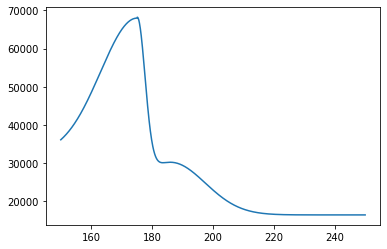

In [ ]:
x = np.arange(150,250,0.1)
y = fit_function_2(x,43106,175,2.6,13800,186,11.4,36000,175,12,16417,32000,175)
plt.plot(x,y)

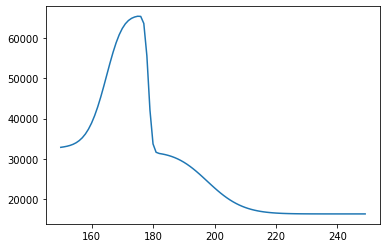

In [ ]:
x_min, x_max = 150, 250
xs = np.arange(x_min,x_max,1)
plt.plot(xs,brightness[x_min:x_max])

A1: 33759.372958316926 +- inf
mu1: 176.95768428929478 +- inf
sig1: 1.408640702129032 +- inf
A2: 14753.026363744313 +- inf
mu2: 183.42007924086005 +- inf
sig2: 12.815576097003268 +- inf
A3: 33791.80532785613 +- inf
mu3: 173.67932925942588 +- inf
sig3: 7.848536703016242 +- inf
d1: 16357.146042032677 +- inf
d3: 32060.611751584183 +- inf
b: 177.0000024798611 +- inf


/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


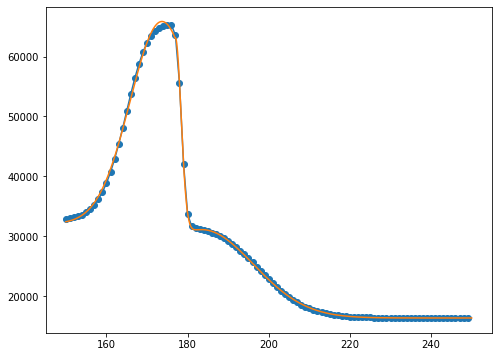

In [ ]:
A1, mu1, sig1, A2, mu2, sig2, A3, mu3,sig3, d1, d3, b = fit_brightness_profile_2(xs,brightness[x_min:x_max],p0=[43106,175,2.6,13800,186,11.4,36000,175,8,16417,32000,177])
x_fit = np.linspace(x_min,x_max,1000)
plt.figure(figsize=(8,6))
plt.plot(xs,brightness[x_min:x_max],marker="o")
plt.plot(x_fit,fit_function_2(x_fit,A1,mu1,sig1,A2,mu2,sig2,A3,mu3,sig3,d1,d3,b))

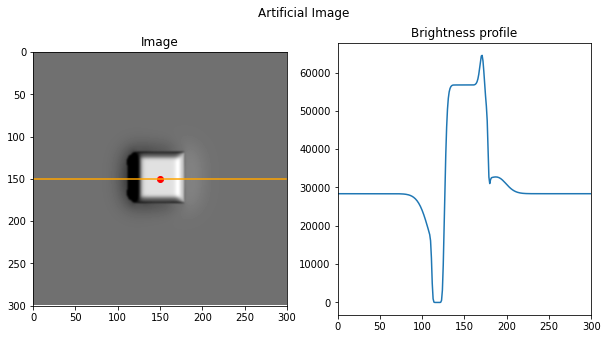

In [ ]:
path_image = "/content/drive/MyDrive/Masterarbeit/Data/ArtificialBoulderImages/"
roi = [25,25,275,275]
image_det = Image.open(path_image+"ID246_50000_30.png")
#image_det = image_det.convert("RGB")
image_det = np.asarray(image_det)

offset = 25
brightness = plot_brightness_profile(image_det,0,150,150,roi,offset,title="Artificial Image",max_length=300,show_plot=True)

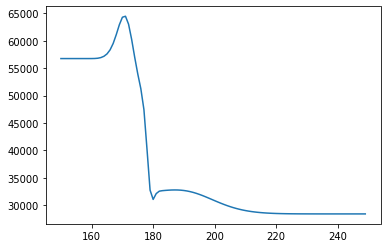

In [ ]:
x_min, x_max = 150, 250
xs = np.arange(x_min,x_max,1)
plt.plot(xs,brightness[x_min:x_max])

A1: 16449.78475154868 +- inf
mu1: 177.08703769158942 +- inf
sig1: 0.8229801600048094 +- inf
A2: 4402.704257410975 +- inf
mu2: 187.93434941027402 +- inf
sig2: 10.989168991583522 +- inf
A3: 8490.237440576255 +- inf
mu3: 170.1618520408027 +- inf
sig3: 2.019767058572134 +- inf
d1: 28386.757713743624 +- inf
d3: 56401.864058368104 +- inf
b: 176.9 +- inf


/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


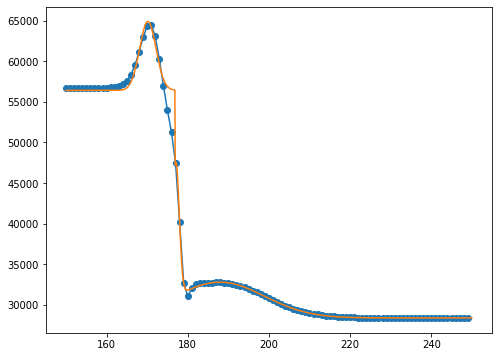

In [ ]:
A1, mu1, sig1, A2, mu2, sig2, A3, mu3,sig3, d1, d3, b = fit_brightness_profile_2(xs,brightness[x_min:x_max],p0=[43106,175,2.6,13800,186,11.4,36000,168,8,16417,32000,176.9])
x_fit = np.linspace(x_min,x_max,1000)
plt.figure(figsize=(8,6))
plt.plot(xs,brightness[x_min:x_max],marker="o")
plt.plot(x_fit,fit_function_2(x_fit,A1,mu1,sig1,A2,mu2,sig2,A3,mu3,sig3,d1,d3,b))